In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy


/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [2]:
series = read_csv('/home/sam/Documents/projects/practice/tme_series/data/clustring 0 average .csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values = series.values

In [3]:
series2 = read_csv('/home/sam/Documents/projects/practice/tme_series/data/clustring 1 average .csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values2 = series2.values

In [4]:
series3 = read_csv('/home/sam/Documents/projects/practice/tme_series/data/clustring 2 average.csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values3 = series3.values

In [5]:
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [6]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [7]:


# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')

	history = {'loss': []}
    
	for i in range(nb_epoch):
		hist = model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		history['loss'].append(hist.history['loss'][0])
		model.reset_states()
    
	return model, history
	# for i in range(nb_epoch):
	# 	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
	# 	model.reset_states()
	# return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

### For Cluster 0

In [8]:
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model, history = fit_lstm(train_scaled, 1, 100, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 2ms/step


array([[-0.10257605],
       [-0.17618485],
       [ 0.18189003],
       [-0.32871968],
       [ 0.03337706],
       [-0.14943357],
       [-0.10655507],
       [-0.13903153],
       [-0.65166587],
       [-0.06267355],
       [ 0.19885305],
       [-0.01627395],
       [ 0.00740219],
       [ 0.13034739],
       [-0.14349182],
       [-0.31087473],
       [-0.44854003],
       [-0.15217021],
       [ 0.21789226],
       [-0.19328983],
       [-0.14198738],
       [ 0.13291557],
       [-0.342169  ],
       [-0.12251864],
       [-0.06973978],
       [ 0.13241467],
       [-0.354153  ],
       [-0.58222055],
       [ 0.06189708],
       [-0.5873779 ],
       [-0.24709353],
       [ 0.00614377],
       [-0.3877071 ],
       [-0.30018634],
       [-0.41742414],
       [-0.40580824],
       [ 0.03545595],
       [-0.5279912 ],
       [-0.26458746],
       [-0.6493359 ],
       [-0.09716298],
       [ 0.03281376],
       [-0.45856354],
       [-0.50392497]], dtype=float32)

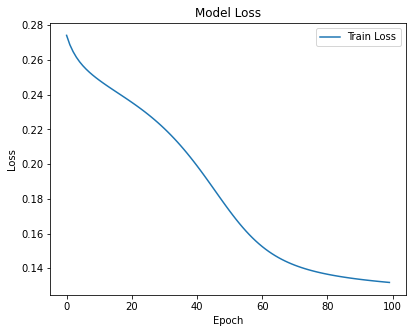

In [14]:
pyplot.figure(figsize=(14, 5))

pyplot.subplot(1, 2, 1)
pyplot.plot(history['loss'], label='Train Loss')
# pyplot.plot(history.history['val_loss'], label='Validation Loss')
pyplot.title('Model Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.legend(loc='upper right')

In [9]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 23ms/step
Month=1, Predicted=1372.149490, Expected=1381.566106
1/1 [==============================] - 0s 17ms/step
Month=2, Predicted=1376.251877, Expected=1374.486594
1/1 [==============================] - 0s 15ms/step
Month=3, Predicted=1375.230730, Expected=1378.116427


Test RMSE: 5.777
Test MAE: 4.689


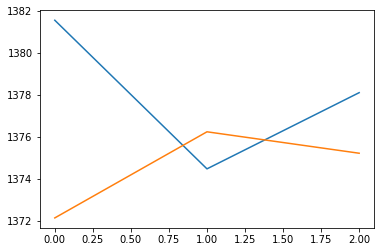

In [10]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()

### For Cluster 1

In [12]:
diff_values2 = difference(raw_values2, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values2, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model, history = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 1ms/step


array([[-0.16977285],
       [-0.50797343],
       [-0.0677322 ],
       [ 0.07324792],
       [-0.32150406],
       [-0.00247933],
       [-0.294748  ],
       [ 0.19136727],
       [-0.04974447],
       [-0.03357324],
       [ 0.28473753],
       [ 0.30753598],
       [-0.09793192],
       [ 0.13909304],
       [ 0.5052967 ],
       [ 0.14299965],
       [ 0.2672669 ],
       [ 0.1168496 ],
       [ 0.16602719],
       [ 0.1593121 ],
       [ 0.14531446],
       [-0.25076953],
       [-0.30215573],
       [-0.14339373],
       [-0.2218873 ],
       [ 0.15777776],
       [ 0.20081192],
       [-0.12277234],
       [-0.24169356],
       [ 0.17077446],
       [ 0.8064991 ],
       [-0.04284055],
       [ 0.1019146 ],
       [-0.16429463],
       [-0.08094728],
       [-0.33817345],
       [-0.49511963],
       [ 0.4941724 ],
       [-0.00425054],
       [-0.21903343],
       [ 0.4052018 ],
       [ 0.07533264],
       [-0.14364904],
       [ 0.3299243 ]], dtype=float32)

In [15]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values2, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values2[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 16ms/step


Month=1, Predicted=276.237069, Expected=275.539862
1/1 [==============================] - 0s 16ms/step
Month=2, Predicted=276.198715, Expected=274.678387
1/1 [==============================] - 0s 19ms/step
Month=3, Predicted=276.167787, Expected=275.965119


Test RMSE: 0.973
Test MAE: 0.807


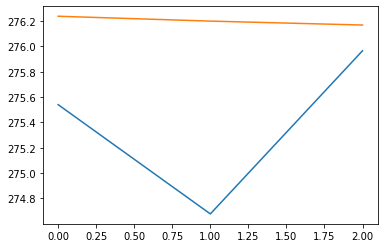

In [16]:
# report performance
rmse = sqrt(mean_squared_error(raw_values2[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values2[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values2[-3:])
pyplot.plot(predictions)
pyplot.show()

### For Cluster 2

In [17]:
diff_values3 = difference(raw_values3, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values3, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model, history = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 1ms/step


array([[-0.14990436],
       [-0.12084777],
       [ 0.04856478],
       [-0.15078136],
       [-0.4209752 ],
       [-0.387115  ],
       [ 0.02502166],
       [-0.43978778],
       [-0.00132288],
       [ 0.30838838],
       [ 0.28993386],
       [-0.16073292],
       [-0.48364493],
       [-0.18527037],
       [-0.41280317],
       [-0.22491992],
       [ 0.32574603],
       [-0.14331649],
       [-0.29428396],
       [ 0.27018538],
       [-0.2169974 ],
       [ 0.28756222],
       [-0.33789253],
       [ 0.4280471 ],
       [ 0.03437342],
       [ 0.23341872],
       [ 0.13915037],
       [ 0.02697984],
       [-0.31911877],
       [-0.28738725],
       [-0.34222645],
       [ 0.31772867],
       [-0.0753138 ],
       [-0.47067344],
       [-0.38612297],
       [-0.3933651 ],
       [-0.14464079],
       [-0.42519486],
       [-0.05790255],
       [-0.1207125 ],
       [ 0.2123439 ],
       [-0.19305177],
       [-0.47253382],
       [-0.23329762]], dtype=float32)

In [18]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values3, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values3[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 15ms/step
Month=1, Predicted=2992.142409, Expected=3001.920000
1/1 [==============================] - 0s 16ms/step
Month=2, Predicted=2993.318813, Expected=3009.820800
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=2997.821427, Expected=2997.898600


Test RMSE: 11.074
Test MAE: 8.786


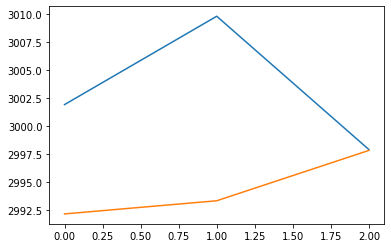

In [19]:
# report performance
rmse = sqrt(mean_squared_error(raw_values3[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values3[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values3[-3:])
pyplot.plot(predictions)
pyplot.show()